In [1]:
import anndata, pickle, os, fnmatch, math, random, copy
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MultipleLocator, LogLocator, LogFormatter, LogFormatterSciNotation, MaxNLocator
import matplotlib.patches as mpatches

In [2]:
'''ADDING PLOTTING PARAMETERS SO EXPORTED IMAGES ARE COMPATIBLE WITH ILLUSTRATOR'''

# Code from: https://jonathansoma.com/lede/data-studio/matplotlib/exporting-from-matplotlib-to-open-in-adobe-illustrator/
mlp.rcParams['pdf.fonttype'] = 42
mlp.rcParams['ps.fonttype'] = 42

In [3]:
'''IMPORTING NECESSARY FUNCTIONS FROM GENERAL FUNCTION FILE'''

%run GeneralFunctions.ipynb

In [4]:
'''NON-PLOTTING FUNCTIONS USED IN THIS FILE'''

def dotPlotCalcs(dictLst, sampleLsts, VC_colorLst, AC_colorLst):
    # Sample data
    sample_labels = []
    labelColors = []
    counts = []
    clustLabels = []
    groupColors = []
    VC_colorLst_copy = copy.deepcopy(VC_colorLst)
    AC_colorLst_copy = copy.deepcopy(AC_colorLst)
    vc_diffColor = VC_colorLst_copy.pop(2)
    ac_diffColor = AC_colorLst_copy.pop(2)
    
    for dictionary, sampleComparLst, vc_color, ac_color in zip(dictLsts, sampleLsts, VC_colorLst_copy, AC_colorLst_copy):
        for i in range(len(sampleComparLst)):
            # Getting sample information 
            if len(sampleComparLst[0]) == 2:
                condition = sampleComparLst[i][0]
                sampleName = sampleComparLst[i][1]
                cortex = sampleName[-5:-3]
                sampleNum = sampleName[:-6]
                sampleLabel = f'{cortex} {condition} ({sampleNum})'
                dictName = sampleName
                sameSex = True 
            else:    
                condition = sampleComparLst[i][0]
                sample1_name = sampleComparLst[i][1]
                sample2_name = sampleComparLst[i][2]
                sample1_num = sample1_name[:-6]
                sample2_num = sample2_name[:-6]
                dictName = f'{sample1_name}_{sample2_name}'
                cortex = sample1_name[-5:-3]
                sameSex = comaringSex(sample1_name, sample2_name)
                
                if cortex not in condition:
                    sampleLabel = f'{cortex} {condition} ({sample1_num} vs. {sample2_num})'
                else: 
                    sampleLabel = f'{condition} ({sample1_num} vs. {sample2_num})'
            
            # Getting counts list for the sample we are looking at 
            countLst = dictionary[dictName]
            counts.append(countLst)
            
            # Getting cluster numbers 
            clusts = [num for num in range(len(countLst))]
            clustLabels.append(clusts)
            
            # Creating a list of the sample labels and their respective colors (acording to the sex of the comparisons)
            sample_labels.append(f'{sampleLabel}')
            if sameSex: labelColors.append(1)
            else: labelColors.append(0)
            
            # Creating a list of each point color according to the sample comparisons 
            if 'VC' in sampleLabel:
                if ('MD' in condition) and ('vs.' in condition): 
                    groupColors.append(vc_diffColor)
                else: groupColors.append(vc_color)
            else:
                if ('MD' in condition) and ('vs.' in condition): 
                    groupColors.append(ac_diffColor)
                else: groupColors.append(ac_color) 

    # Generate random x and y coordinates for each dot in each sample and getting the cluster numbers for each point
    x_coords = []
    y_coords = []
    pointLabel = []
    pointColors = []
    y = 0
    for lst, color, clusterLst in zip(counts, groupColors, clustLabels):
        y += 1
        for num, clust in zip(lst, clusterLst):
            jitter = random.uniform(-0.1, 0.1)
            y_coords.append(y + jitter)
            x_coords.append(num)
            pointColors.append(color)
            pointLabel.append(clust) 
    
    return(x_coords, y_coords, pointColors, pointLabel, sample_labels, labelColors)

In [5]:
'''PLOTTING FUNCTIONS USED IN THIS FILE'''

# Dot Plot: Sample vs. Number of DE Genes 
    # figSize = tuple containing the size you want your figure to be (W, H)
    # x_coords = list containing all of the dot's x coordinates (obtained through 'dotPlotCalcs' function)
    # y_coords = list containing all of the dot's y coordinates (obtained through 'dotPlotCalcs' function)
    # pointColors = list containing each point's color (obtained through 'dotPlotCalcs' function) 
    # sample_labels = list containing the label for each sample (y axis) (obtained through 'dotPlotCalcs' function)
    # VC_colorLst = list containing the colors for each group of VC samples 
    # AC_colorLst = list containing the colors for each group of AC samples 
    # ax = axis object of the matplotlib subplot
def createDotPlot(x_coords, y_coords, pointColors, pointLabel, sample_labels, VC_colorLst, AC_colorLst, labelColors, ax):
    # Font sizes for the labels in the dot plot
    axis_fontsize = 35
    label_fontsize = 30
    title_fontsize = 40
    
    # Plotting each point using the coords found in the x_coords and y_coords lists 
    for x, y, color, clust in zip(x_coords, y_coords, pointColors, pointLabel):
#         ax.scatter(x, y, s=125)
        ax.annotate(str(clust), (x, y), color=color, ha="center", va="center", fontsize=25)

    # Making a line to mark 0 on the graph 
    line_x = [0, 0]
    line_y = [0, (len(sample_labels))]  
    ax.plot(line_x, line_y, color='lightgray', linewidth=1)    
    
    # Removing axis lines on the graph 
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Setting x axis parameters 
    ax.set_xlim(-10, 30)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('Number of Genes', fontsize=axis_fontsize)
    ax.tick_params(axis='x', labelsize=30)
    
    # Setting y axis parameters 
    ax.set_yticks([i for i in range(1, (len(sample_labels)+1))], sample_labels, fontsize=label_fontsize)
    ax.set_ylabel('Sample Comparisons', fontsize=axis_fontsize)
    ax.set_title(f'Number of Genes per Cluster with DE Score >20 or <-20 and a Fold Change >2 or <0.5 for All Comparisons', 
             fontsize=title_fontsize, y=1.07)
    
    # Changing the color of y labels 
    labelsToColor = [index for index, value in enumerate(labelColors) if value == 1]
    ax.tick_params(axis='y', which='both', labelcolor='black')
    count = 0
    for label in ax.get_yticklabels():
        if count in labelsToColor:
            label.set_color('red')
        count += 1
    
    # Creating legend labels 
    patchC = mpatches.Patch(color=VC_colorLst[0], label='VC Within Sample')
    patchD = mpatches.Patch(color=AC_colorLst[0], label='AC Within Sample')
    patchE = mpatches.Patch(color=VC_colorLst[2], label='VC Plasticity Comparisons')
    patchF = mpatches.Patch(color=AC_colorLst[2], label='AC Plasticity Comparisons')
    patchG = mpatches.Patch(color=VC_colorLst[3], label='VC Hemispheric Comparisons')
    patchH = mpatches.Patch(color=AC_colorLst[3], label='AC Hemispheric Comparisons')
    ax.legend(handles=[patchC, patchD, patchE, patchF, patchG, patchH], loc='lower right', 
              fontsize=label_fontsize)
    
    
# Scatter Plot: Differential Expression vs. Fold Change 
    # 
def diffExpVSfoldChange(dictionary, sampleLst, ax, folderName):
    if len(sampleLst) == 2:     
        condition = sampleLst[0]
        sampleName = sampleLst[1]

        deScore = f'{sampleName} Half 1_DE_Score'
        title = f'Sample {sampleName}'

    else:
        condition = sampleLst[0]
        sample1_name = sampleLst[1]
        sample2_name = sampleLst[2]
        sample1_num = sample1_name[:-6]
        sample2_num = sample2_name[:-6]
        cortex = sample1_name[-5:-3]

        sampleName = f'{condition}_{sample1_name}_{sample2_name}'
        deScore = f'{sample1_name}_DE_Score'
        if cortex not in condition:
            title = f'{cortex} {condition} ({sample1_num} vs. {sample2_num})'
        else: 
            title = f'{condition} ({sample1_num} vs. {sample2_num})'
                
    obj = sc.read(f'F:/SampleData/{folderName}/{sampleName}.h5ad')

    foldChange = dictionary[sampleName]
    diffExp = obj.var[deScore]

    ax.scatter(foldChange, diffExp)
    ax.set_xlabel('Fold Change', fontsize = 20)
    ax.set_ylabel('Differential Expression', fontsize = 20)
    ax.set_title(f'{title}', fontsize = 25)
    
# Histogram: Number of Genes vs. Mean Count 
    # sampleObj = the sample's AnnData object you want to plot the mean_counts for 
    # ax = the axis object for subplot
def nucCountHist(folderName, sampleName, ax):
    
    obj = sc.read(f'F:/SampleData/{folderName}/{sampleName}.h5ad')
    
    clustLst = list(np.unique(obj.obs['leiden_0.3']))
    sortClustLst = sortClust(clustLst)

    nucCount = []

    for clust in sortClustLst:
        clustObj = obj[obj.obs['leiden_0.3'].isin([clust]),:]
        sc.pp.calculate_qc_metrics(clustObj, percent_top=None, log1p=False, inplace=True)

        clustNucCount = clustObj.n_obs
        nucCount.append(clustNucCount)
    
    ax.text(0.95, 0.95, f'Total # of Nuclei = {obj.n_obs}', fontsize=20, ha='right', va='top', transform=ax.transAxes)
    ax.bar(sortClustLst, nucCount)
    
    # Graph axis params 
    axisTitle_fontSize = 25
    axisNum_fontSize = 20 
    
    ax.set_xlabel('Clusters', fontsize = axisTitle_fontSize)
    ax.tick_params(axis='x', labelsize=axisNum_fontSize)
    ax.set_ylabel('Number of Nuclei', fontsize = axisTitle_fontSize)
    ax.tick_params(axis='y', labelsize=axisNum_fontSize)
#     ax.set_xticks(sortClustLst, fontsize=35)
#     ax.set_yticks([500, 1000, 1500, 2000, 2500], fontsize=35)
            
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [7]:
sampleNameLst = [['MD Contra. Hem. (L)', '1_VC20L'], ['MD Contra. Hem. (L)', '2_AC20L'], ['MD Ipsi. Hem. (R)', '3_VC20R'], 
                 ['MD Ipsi. Hem. (R)', '4_AC20R'], ['Deafened', '5_VC22L'], ['Deafened', '6_AC22L'], ['Control', '7_VC24L'],
                 ['Control', '8_AC24L'], ['Control', '9_VC23L'], ['Deafened', '10_VC25L'], ['Deafened', '13_AC25L'], 
                 ['Control', '14_AC23L'], ['MD Contra. Hem. (L)', '16_VC19L'], ['MD Ipsi. Hem. (R)', '17_VC19R'], 
                 ['MD Contra. Hem. (L)', '19_AC19L'], ['MD Ipsi. Hem. (R)', '20_AC19R']]

bioRepComparisonLst = [['VC Control', '7_VC24L', '9_VC23L'], ['AC Control', '8_AC24L', '14_AC23L'], 
                       ['VC Deafened', '5_VC22L', '10_VC25L'], ['AC Deafened', '6_AC22L', '13_AC25L'], 
                       ['VC MD Contra. Hem. (L)', '16_VC19L', '1_VC20L'], ['AC MD Contra. Hem. (L)', '19_AC19L', '2_AC20L'], 
                       ['VC MD Ipsi. Hem. (R)', '17_VC19R', '3_VC20R'], ['AC MD Ipsi. Hem. (R)', '20_AC19R', '4_AC20R']]

plastComparLst = [['VC Deaf vs. Control', '5_VC22L', '7_VC24L'], ['VC Deaf vs. Control', '5_VC22L', '9_VC23L'], 
                  ['VC Deaf vs. Control', '10_VC25L', '7_VC24L'], ['VC Deaf vs. Control', '10_VC25L', '9_VC23L'],
                  ['AC Deaf vs. Control', '6_AC22L', '8_AC24L'], ['AC Deaf vs. Control', '6_AC22L', '14_AC23L'],
                  ['AC Deaf vs. Control', '13_AC25L', '8_AC24L'], ['AC Deaf vs. Control', '13_AC25L', '14_AC23L'],
                  ['VC MD vs. Control', '16_VC19L', '7_VC24L'], ['VC MD vs. Control', '16_VC19L', '9_VC23L'],
                  ['VC MD vs. Control', '1_VC20L', '7_VC24L'], ['VC MD vs. Control', '1_VC20L', '9_VC23L'],
                  ['AC MD vs. Control', '19_AC19L', '8_AC24L'], ['AC MD vs. Control', '19_AC19L', '14_AC23L'],
                  ['AC MD vs. Control', '2_AC20L', '8_AC24L'], ['AC MD vs. Control', '2_AC20L', '14_AC23L']]

hemComparLst = [['VC Contra (L) vs. Ipsi Hem (R)', '16_VC19L', '17_VC19R'], 
                ['AC Contra (L) vs. Ipsi Hem (R)', '19_AC19L', '20_AC19R'], 
                ['VC Contra (L) vs. Ipsi Hem (R)', '1_VC20L', '3_VC20R'], 
                ['AC Contra (L) vs. Ipsi Hem (R)', '2_AC20L','4_AC20R']]

In [16]:
# Reading in the sample dictionaries
diffExp_withinSample =  readDict('F:/FigureCalculations/Figure4/diffExp_WithinSample')
diffExp_bioRep = readDict('F:/FigureCalculations/Figure4/diffExp_BiologicalReplicaSamples')
diffExp_plastCompar = readDict('F:/FigureCalculations/Figure4/diffExp_PlasticityComparisons')
diffExp_hemiCompar =  readDict('F:/FigureCalculations/Figure4/diffExp_HemiComparisons')

# List of lists
dictLsts = [diffExp_withinSample, diffExp_bioRep, diffExp_plastCompar, diffExp_hemiCompar]
sampleLsts = [sampleNameLst, bioRepComparisonLst, plastComparLst, hemComparLst]
VC_colorLst = ['maroon', 'lightcoral', 'darkred', 'red', 'tomato']
AC_colorLst = ['midnightblue', 'skyblue', 'blue', 'deepskyblue', 'royalblue']

x_coords, y_coords, pointColors, pointLabel, sample_labels, labelColors = dotPlotCalcs(dictLsts, sampleLsts, VC_colorLst, 
                                                                                       AC_colorLst)

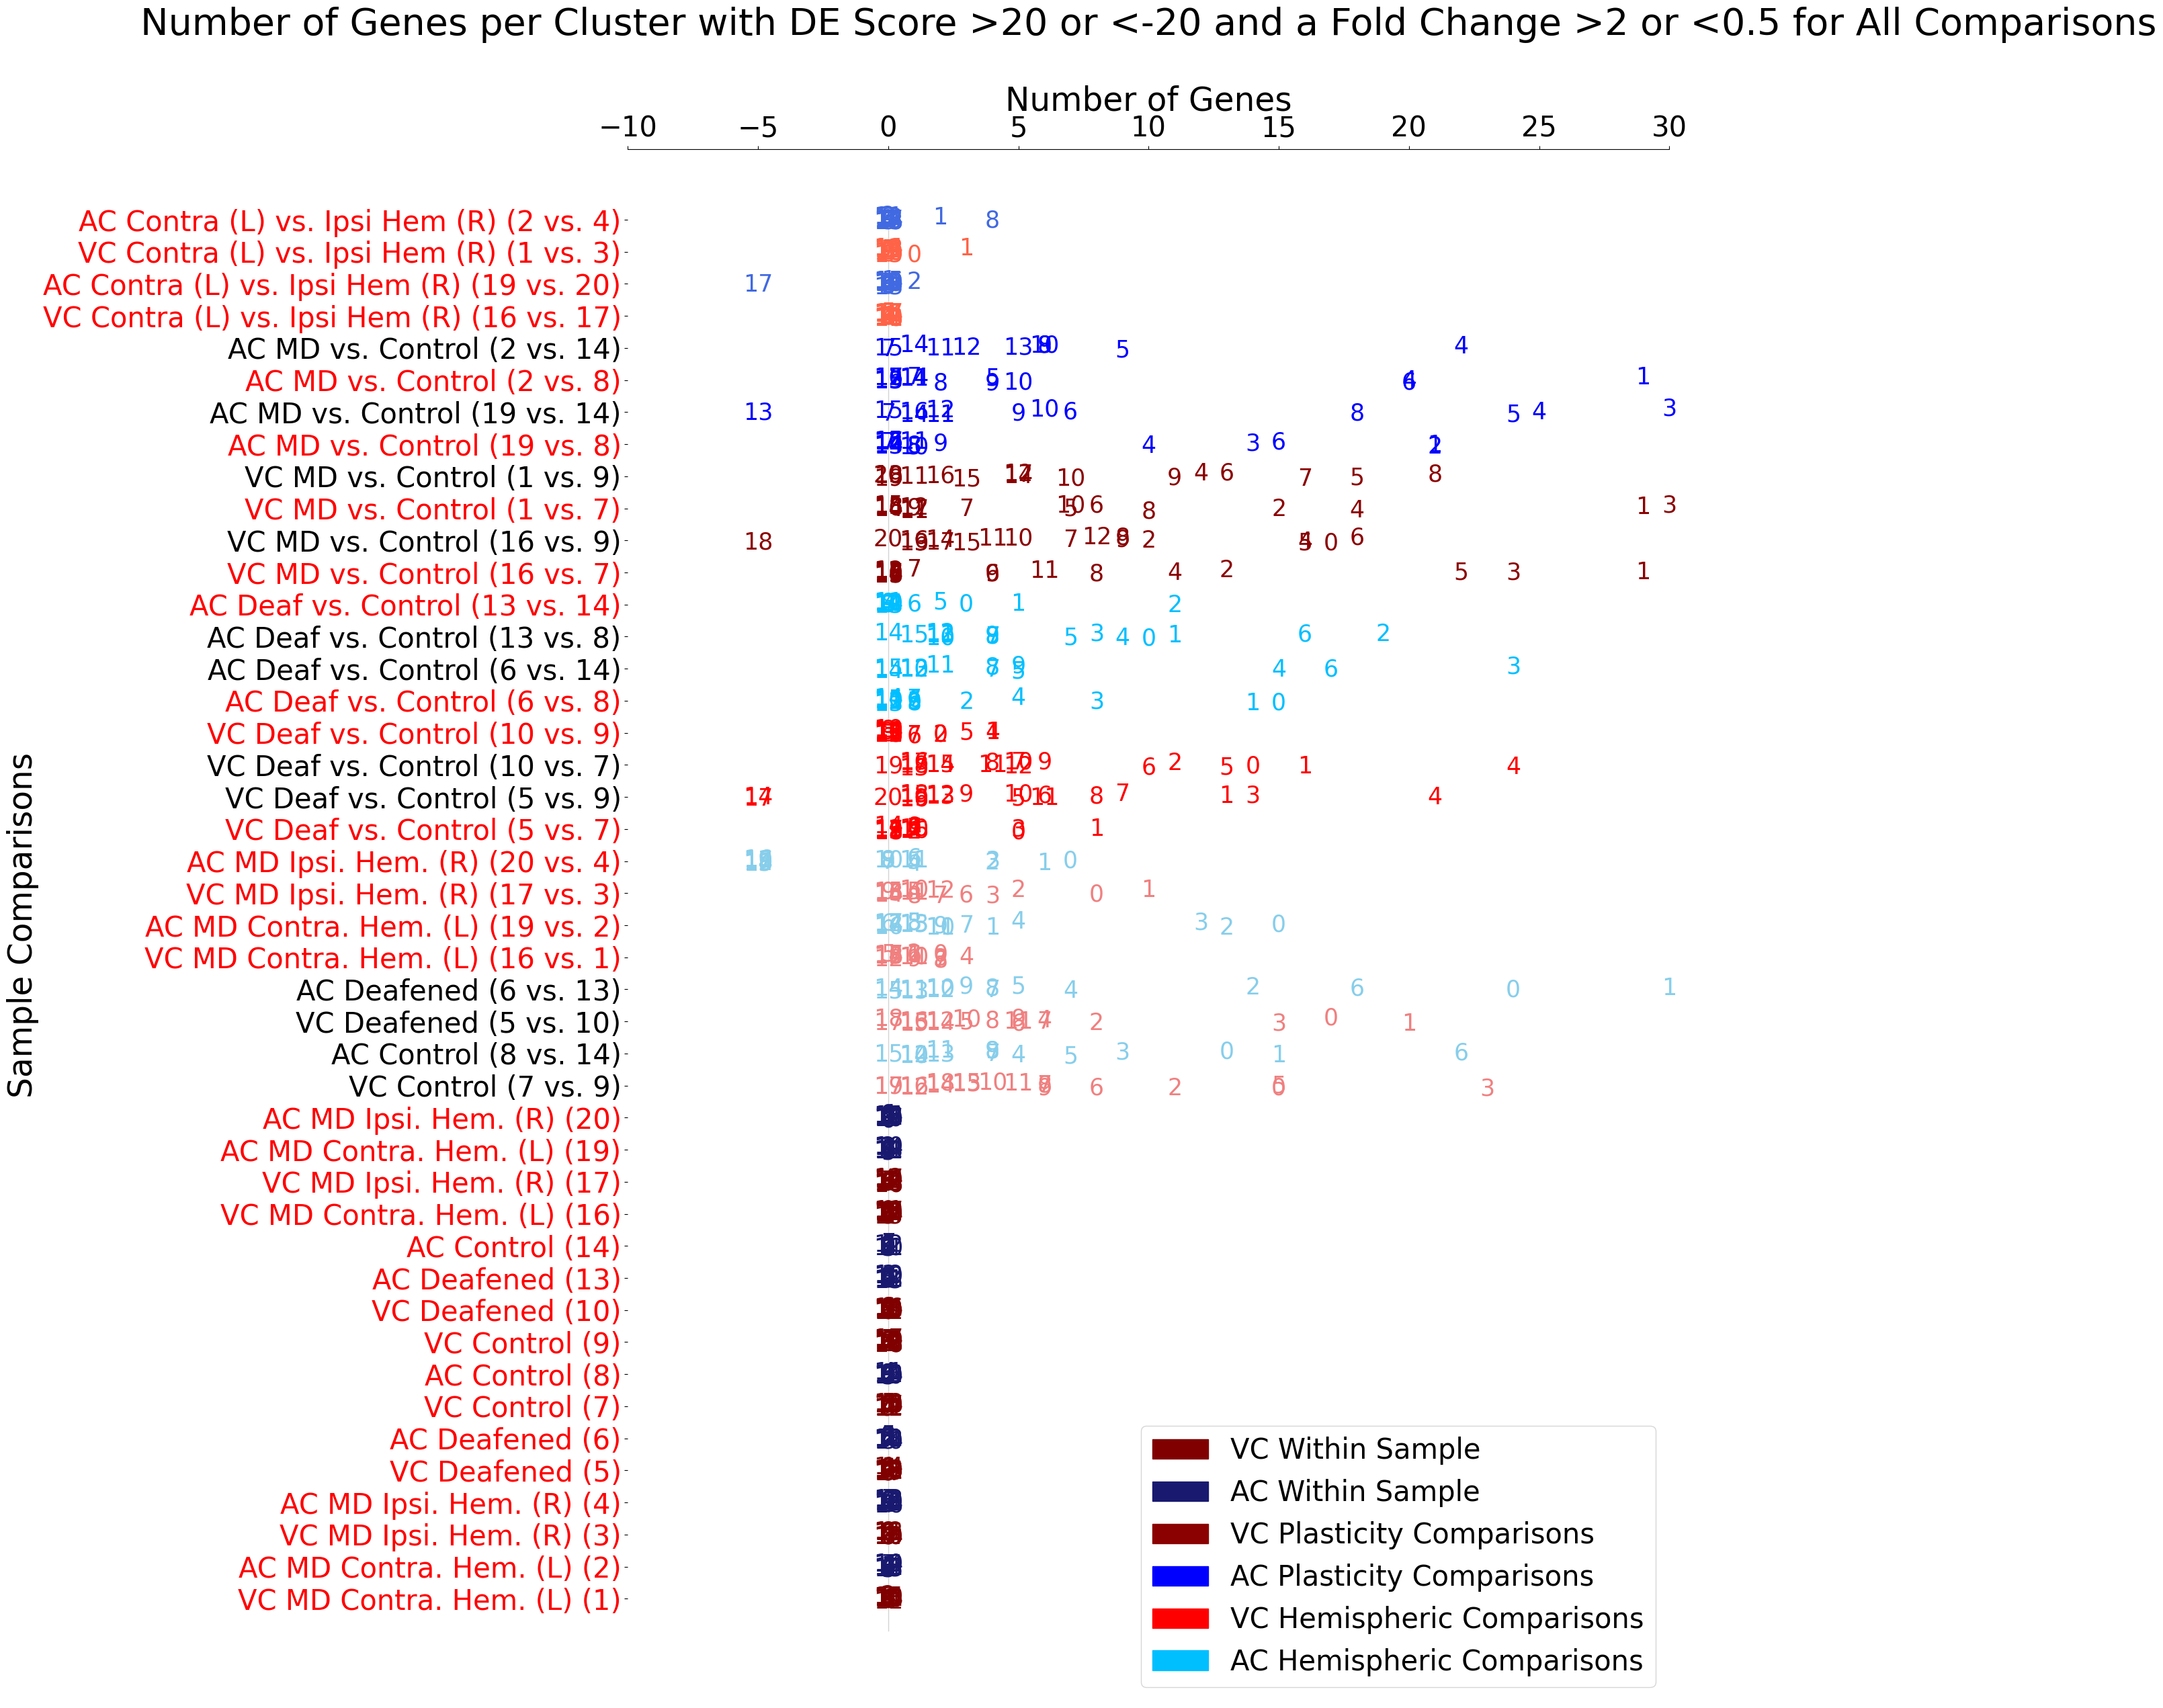

In [17]:
fig, ax = plt.subplots(figsize=(20, 30))
createDotPlot(x_coords, y_coords, pointColors, pointLabel, sample_labels, VC_colorLst, AC_colorLst, labelColors, ax)

In [6]:
bioRepComparisonLst = [['Control', '7_VC24L', '9_VC23L'], ['Control', '8_AC24L', '14_AC23L'], 
                       ['Deafened', '5_VC22L', '10_VC25L'], ['Deafened', '6_AC22L', '13_AC25L'], 
                       ['MD Contra. Hem. (L)', '16_VC19L', '1_VC20L'], ['MD Contra. Hem. (L)', '19_AC19L', '2_AC20L'], 
                       ['MD Ipsi. Hem. (R)', '17_VC19R', '3_VC20R'], ['MD Ipsi. Hem. (R)', '20_AC19R', '4_AC20R']]

plastComparLst1 = [['Deaf VC vs. Control VC', '5_VC22L', '7_VC24L'], ['Deaf VC vs. Control VC', '5_VC22L', '9_VC23L'], 
                  ['Deaf VC vs. Control VC', '10_VC25L', '7_VC24L'], ['Deaf VC vs. Control VC', '10_VC25L', '9_VC23L'],
                  ['Deaf AC vs. Control AC', '6_AC22L', '8_AC24L'], ['Deaf AC vs. Control AC', '6_AC22L', '14_AC23L'],
                  ['Deaf AC vs. Control AC', '13_AC25L', '8_AC24L'], ['Deaf AC vs. Control AC', '13_AC25L', '14_AC23L']]
                  
plastComparLst2 = [['MD VC vs. Control VC', '16_VC19L', '7_VC24L'], ['MD VC vs. Control VC', '16_VC19L', '9_VC23L'],
                  ['MD VC vs. Control VC', '1_VC20L', '7_VC24L'], ['MD VC vs. Control VC', '1_VC20L', '9_VC23L'],
                  ['MD AC vs. Control AC', '19_AC19L', '8_AC24L'], ['MD AC vs. Control AC', '19_AC19L', '14_AC23L'],
                  ['MD AC vs. Control AC', '2_AC20L', '8_AC24L'], ['MD AC vs. Control AC', '2_AC20L', '14_AC23L']]

hemComparLst = [['VC Contra (L) vs. Ipsi Hem (R)', '16_VC19L', '17_VC19R'], 
                ['AC Contra (L) vs. Ipsi Hem (R)', '19_AC19L', '20_AC19R'], 
                ['VC Contra (L) vs. Ipsi Hem (R)', '1_VC20L', '3_VC20R'], 
                ['AC Contra (L) vs. Ipsi Hem (R)', '2_AC20L','4_AC20R']]

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

Only considering the two last: ['. (L)_16_VC19L_1_VC20L', '.h5ad'].
Only considering the two last: ['. (L)_16_VC19L_1_VC20L', '.h5ad'].


C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

Only considering the two last: ['. (L)_19_AC19L_2_AC20L', '.h5ad'].
Only considering the two last: ['. (L)_19_AC19L_2_AC20L', '.h5ad'].


C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

Only considering the two last: ['. (R)_17_VC19R_3_VC20R', '.h5ad'].
Only considering the two last: ['. (R)_17_VC19R_3_VC20R', '.h5ad'].


C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

Only considering the two last: ['. (R)_20_AC19R_4_AC20R', '.h5ad'].
Only considering the two last: ['. (R)_20_AC19R_4_AC20R', '.h5ad'].


C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

MemoryError: Unable to allocate 28.5 MiB for an array with shape (7480647,) and data type int32

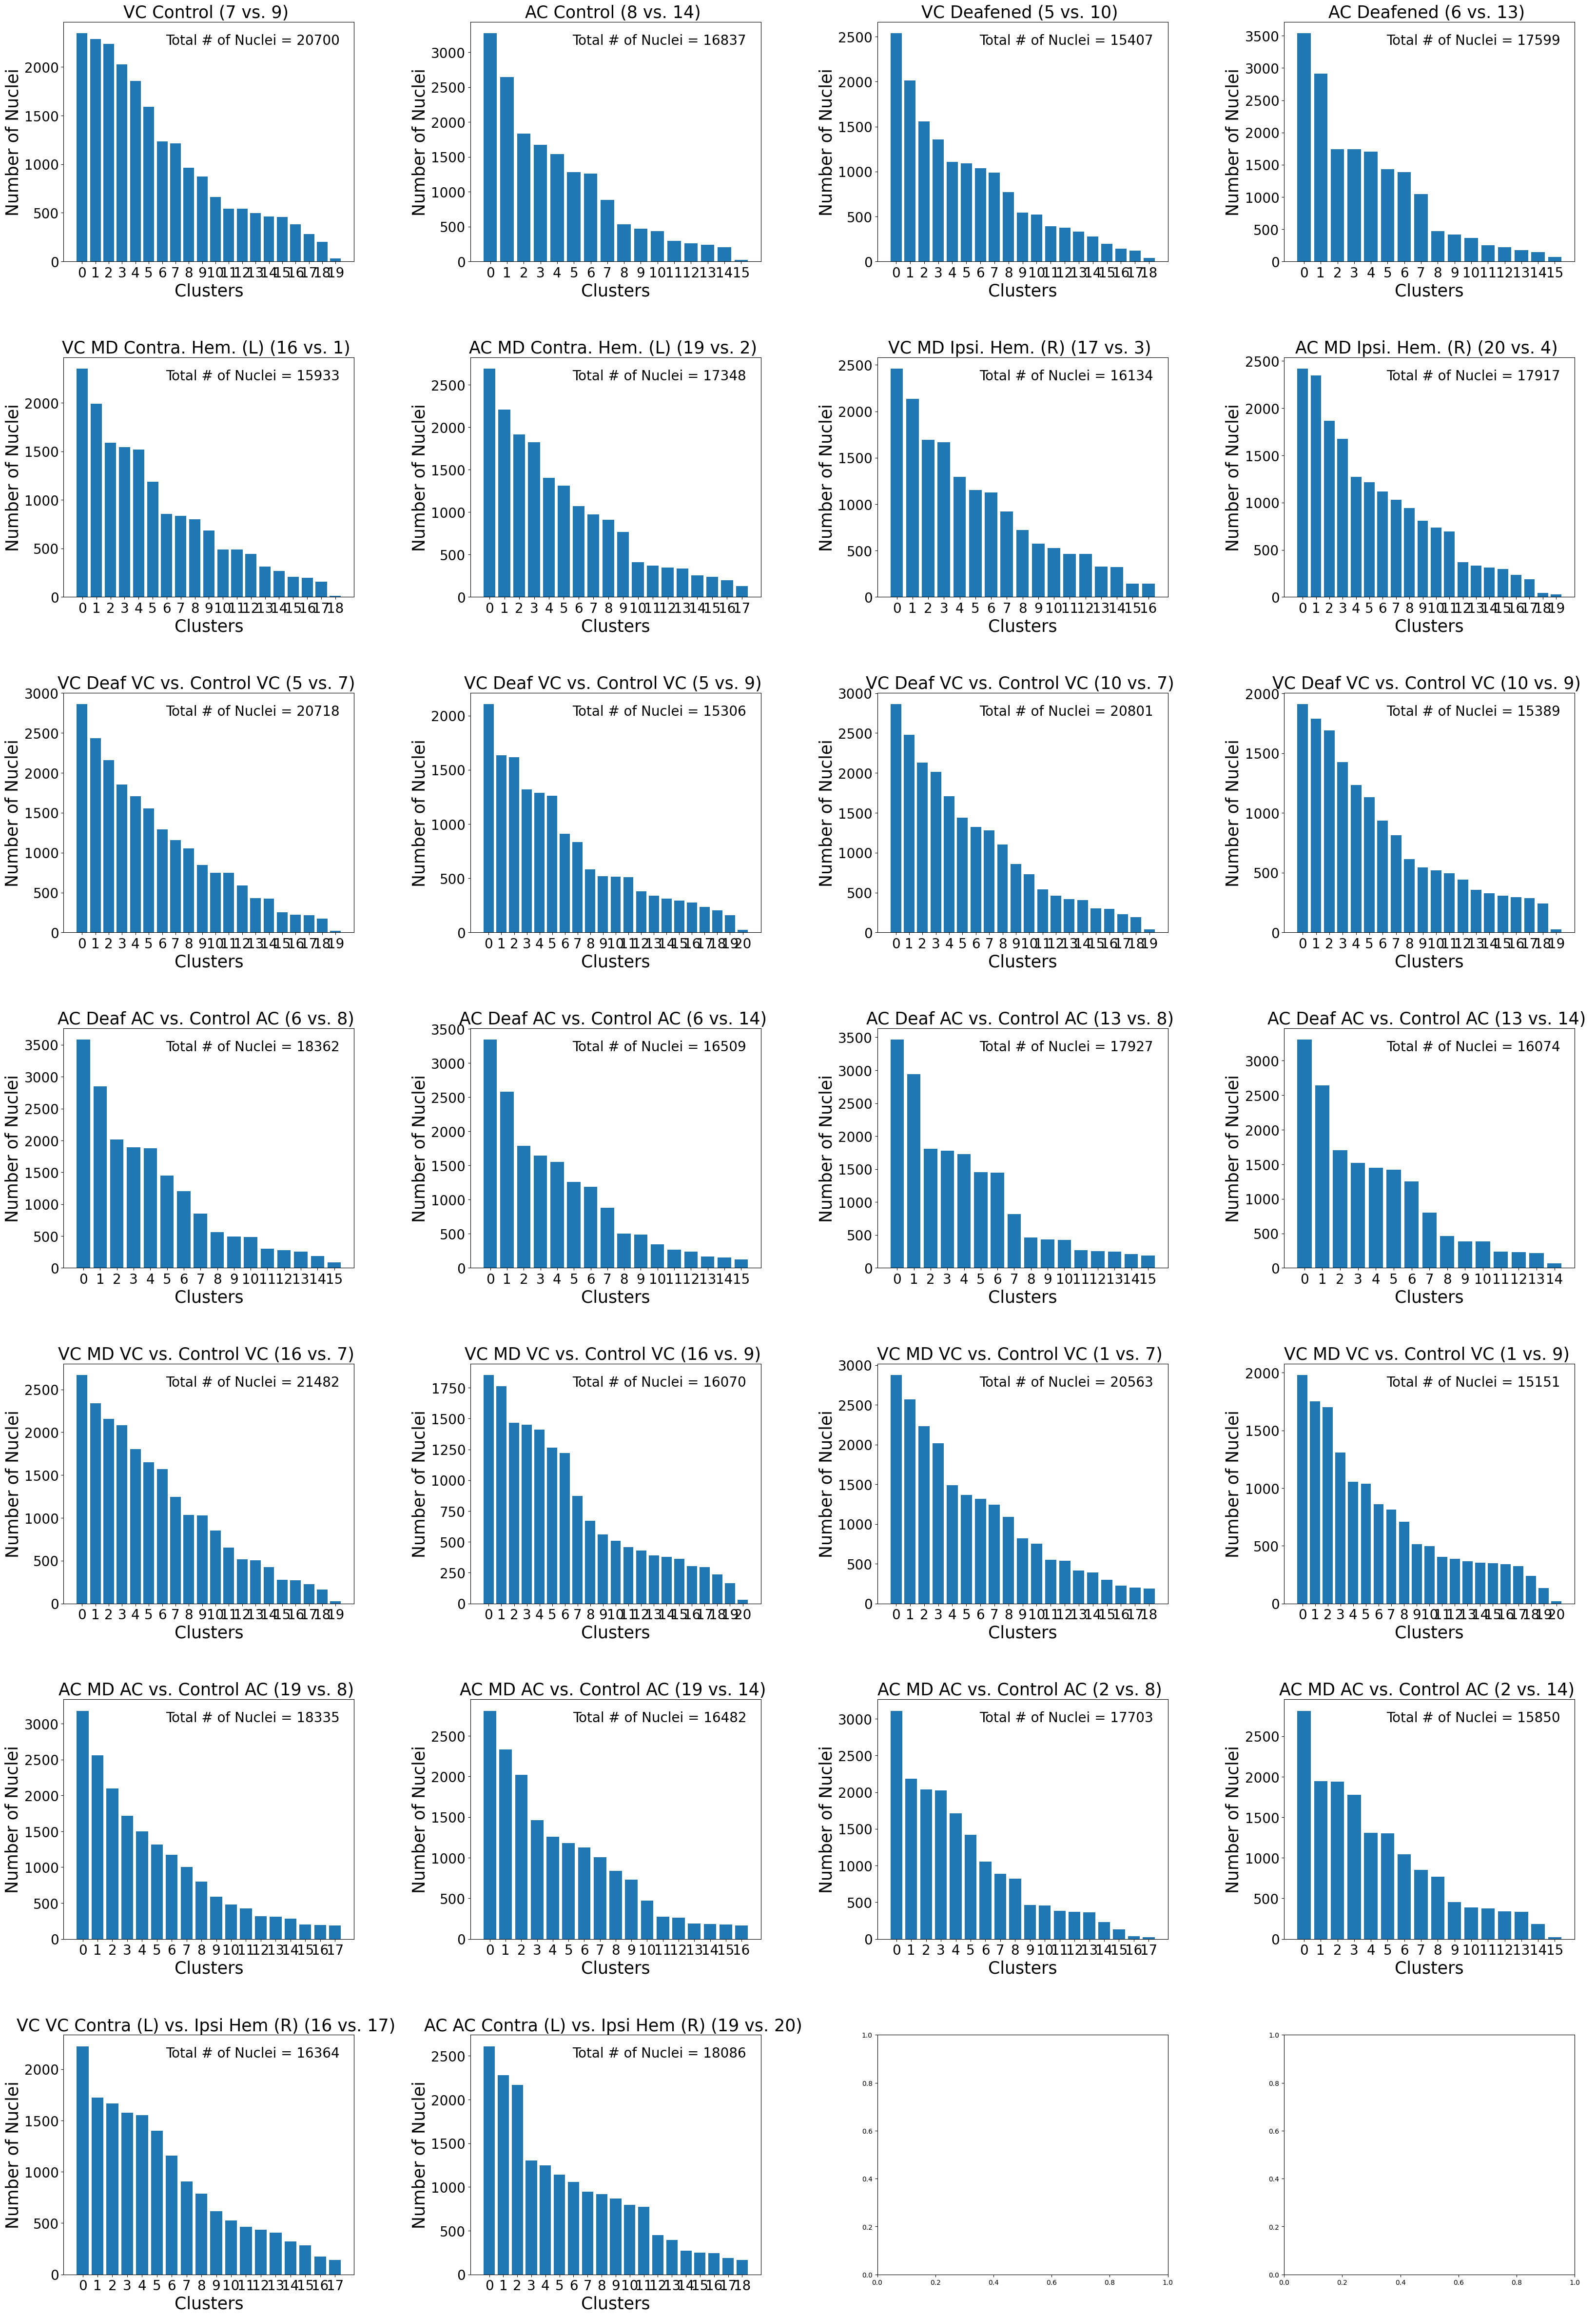

In [7]:
rows = 7
cols = 4 

sampleLsts = [bioRepComparisonLst, plastComparLst1, plastComparLst2, hemComparLst]
folderNames = ['BiologicalReplicaSamples', 'PlasticityComparisons', 'PlasticityComparisons', 'HemisphericComparisons']
fig, axs = plt.subplots(rows, cols, figsize=(40,60), dpi=100)

rowIdx = [num for num in range(rows)]
colIdx = [num for num in range(cols)]

for sampleCompar, folderName  in zip(sampleLsts, folderNames):
    for sampleLst in sampleCompar:
            condition = sampleLst[0]
            sample1_name = sampleLst[1]
            sample2_name = sampleLst[2]
            cortex = sample1_name[-5:-3]
            sample1_num = sample1_name[:-6]
            sample2_num = sample2_name[:-6]
            fileName = f'{condition}_{sample1_name}_{sample2_name}'
            
            if colIdx == []:
                colIdx = [num for num in range(cols)]
                rowIdx.pop(0)
            
            i_row = rowIdx[0]
            i_col = colIdx.pop(0)
            axObj = axs[i_row, i_col]
            nucCountHist(folderName, fileName, axObj)
            
            if 'VC' not in condition or 'AC' not in condition:
                axObj.set_title(f'{cortex} {condition} ({sample1_num} vs. {sample2_num}) ', fontsize = 25)
            else:
                axObj.set_title(f'{condition} ({sample1_num} vs. {sample2_num}) ', fontsize = 25)

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


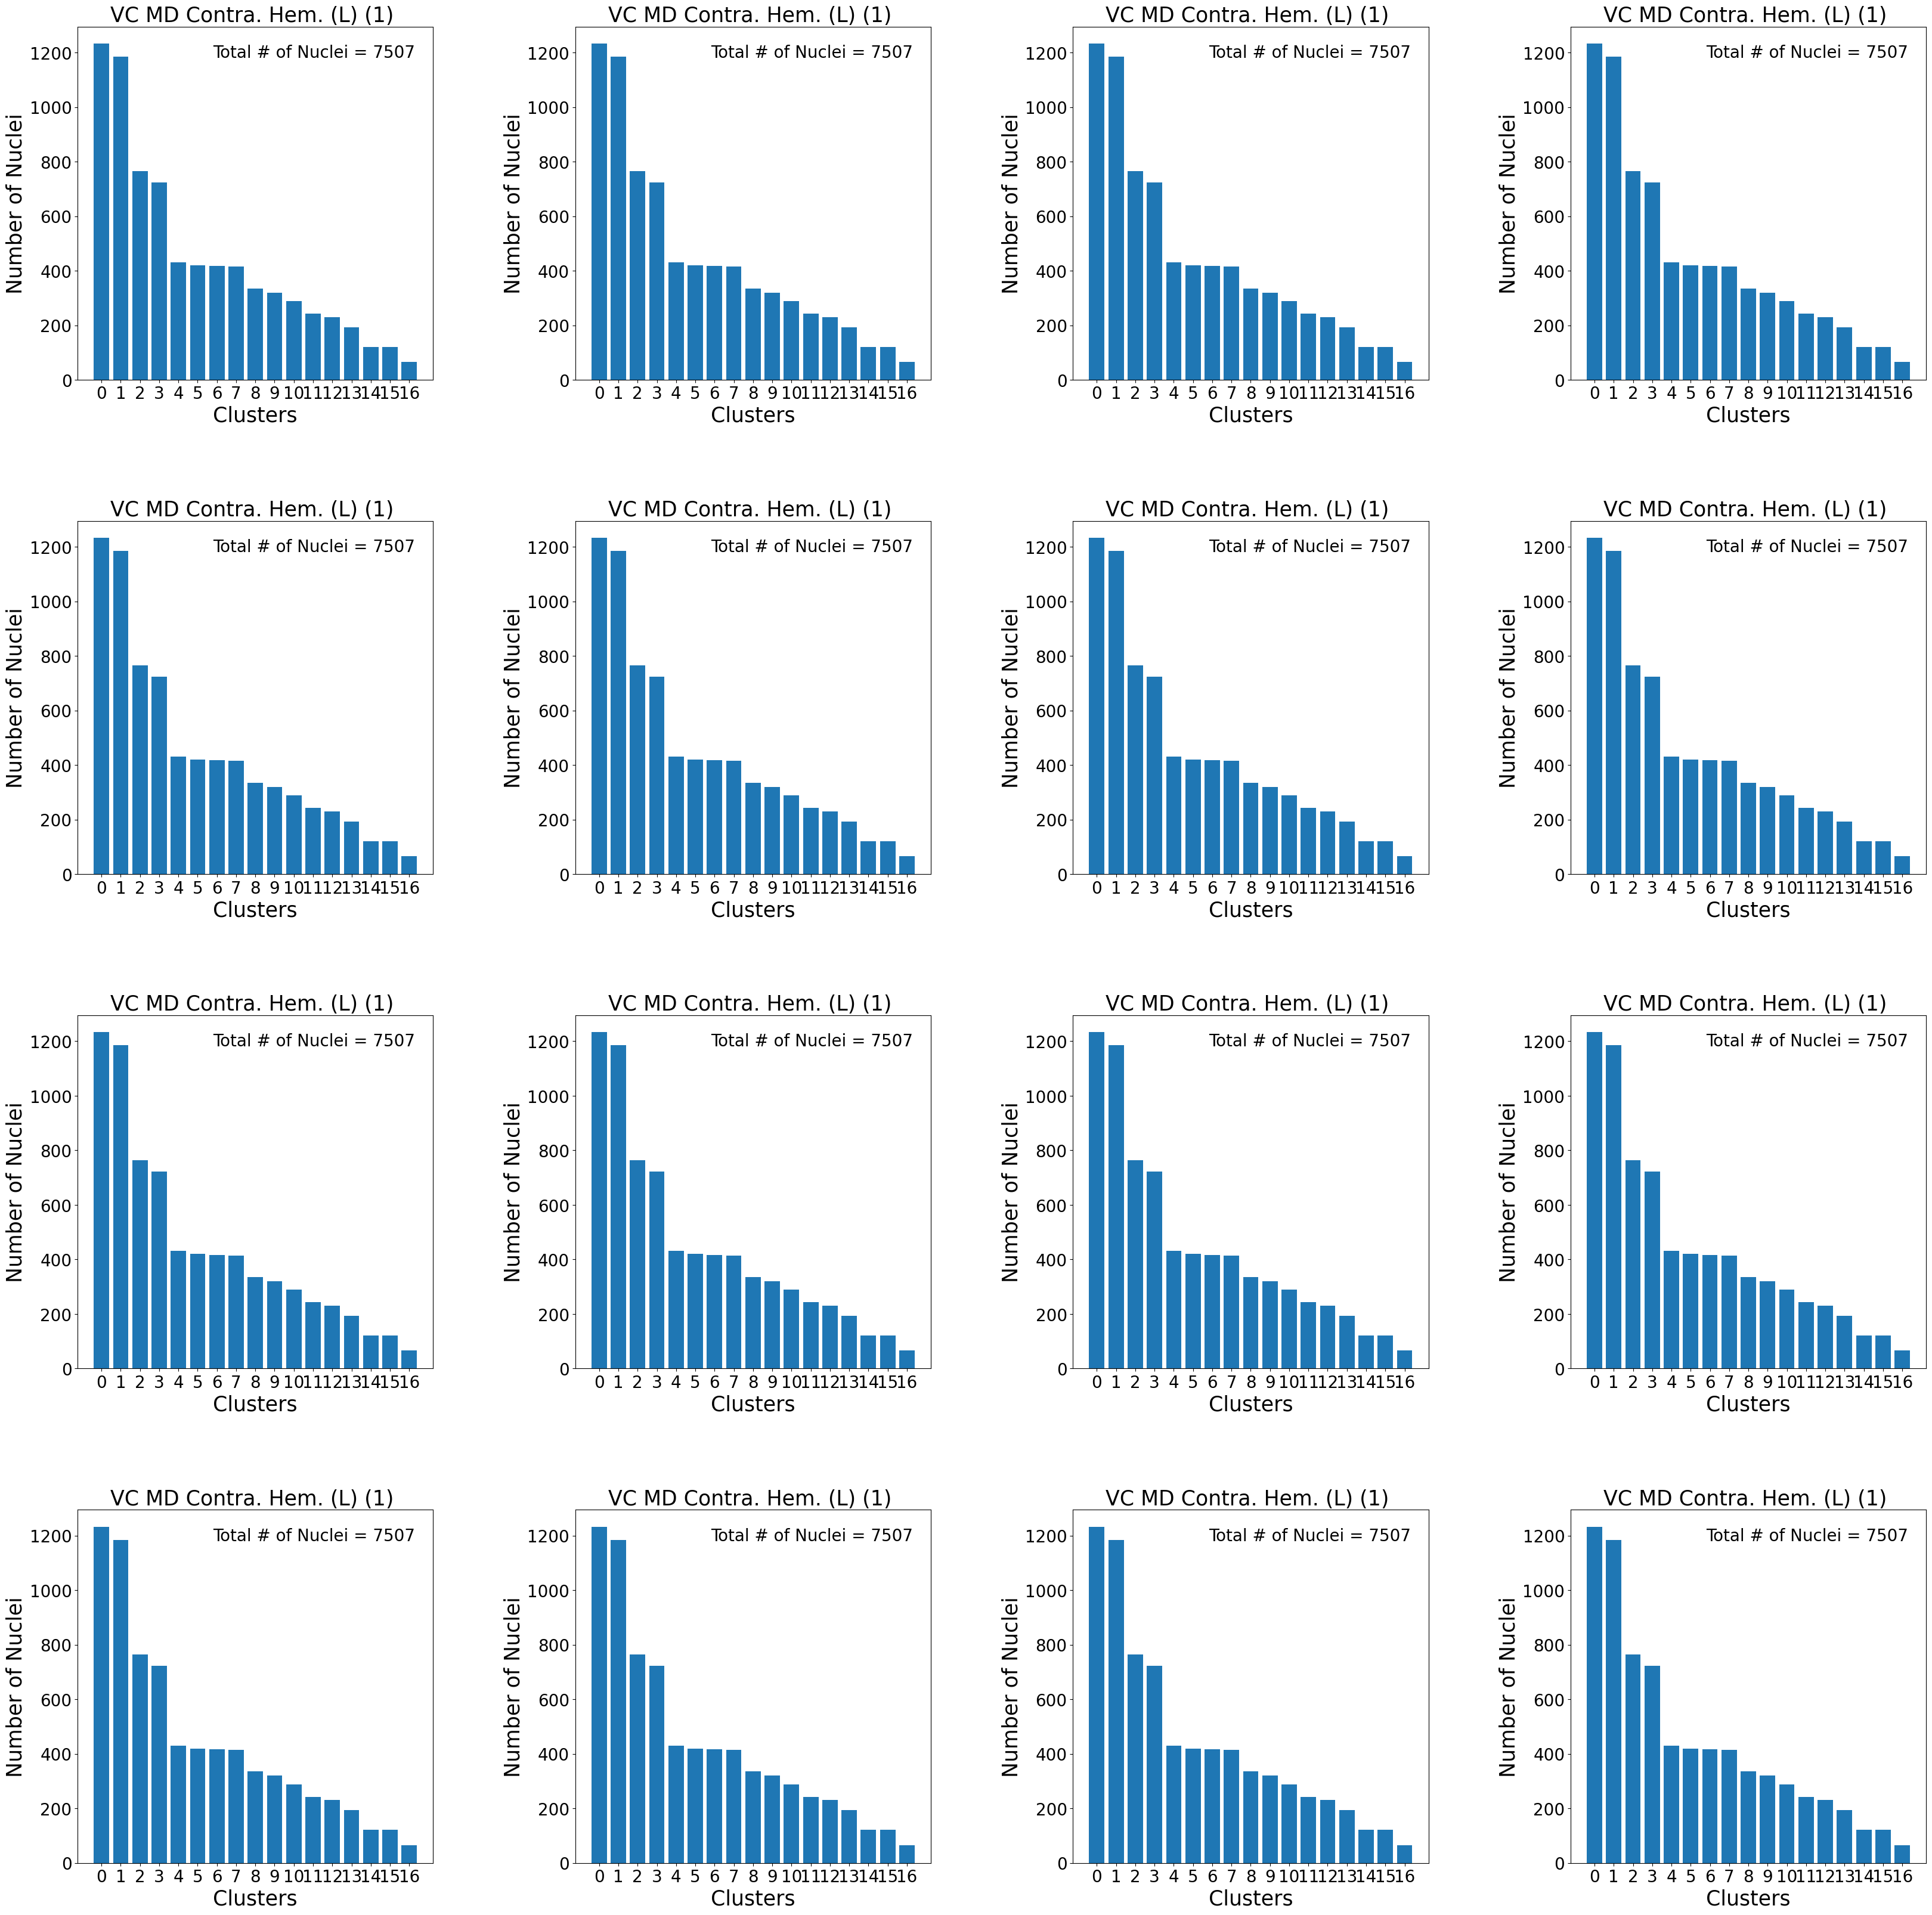

In [22]:
rows = 4
cols = 4 

sampleLsts = sampleNameLst
folderName = 'IndividualSamples'
fig, axs = plt.subplots(rows, cols, figsize=(40,40), dpi=100)

rowIdx = [num for num in range(rows)]
colIdx = [num for num in range(cols)]

for i_row in range(rows):
    for i_col in range(cols):
            sampleLst = sampleLsts[0]
            condition = sampleLst[0]
            sampleName = sampleLst[1]
            cortex = sampleName[-5:-3]
            sampleNum = sampleName[:-6]
            
            if colIdx == []:
                colIdx = [num for num in range(cols)]
                rowIdx.pop(0)
            
            axObj = axs[i_row, i_col]
            nucCountHist(folderName, sampleName, axObj)
            
            if 'VC' not in condition or 'AC' not in condition:
                axObj.set_title(f'{cortex} {condition} ({sampleNum}) ', fontsize = 25)
            else:
                axObj.set_title(f'{condition} ({sampleNum})', fontsize = 25)